In [42]:
import os
import time
import copy
import glob
import cv2
import shutil

import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np

In [43]:
data_path = './data/catanddog/train/'

transform = transforms.Compose(
    [
        transforms.Resize([256, 256]),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ])

train_dataset = torchvision.datasets.ImageFolder(
    data_path,
    transform = transform
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = 32,
    num_workers = 8,
    shuffle = True
)

print(len(train_dataset))

385


In [44]:
resnet18 = models.resnet18(pretrained = True)

c:\Users\sangil\anaconda3\envs\sangil\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\sangil\anaconda3\envs\sangil\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
resnet18.fc = nn.Linear(512, 2)

In [46]:
model = models.resnet18(pretrained = True)

for param in model.parameters():
    param.requires_grad = False
    
model.fc = torch.nn.Linear(512, 2)
for param in model.fc.parameters():
    param.requores_grad = True
    
optimizer = torch.optim.Adam(model.fc.parameters())
cost = torch.nn.CrossEntropyLoss()

In [47]:
def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=13, is_train=True):
    since = time.time()
    acc_history = []
    loss_history = []
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-'*10)
        
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            model.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0) # 출력 결과와 레이블의 오차를 계산한 결과를 누적하여 저장
            running_corrects += torch.sum(preds == labels.data) # 츨력 결과와 레이블이 동일한지 확인한 결과를 누적하여 저장
        
        epoch_loss = running_loss / len(dataloaders.dataset) # 평균 오차 계산
        epoch_acc = running_corrects.double() / len(dataloaders.dataset) # 평균 정확도 계산
        
        print("Loss: {:.4f} Acc: {:.4f}".format(epoch_loss, epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            
        acc_history.append(epoch_acc.item())
        
        loss_history.append(epoch_loss)
        torch.save(model.state_dict() , os.path.join("./data/catanddog/",
                   '{0:0=2d}.pth'.format(epoch)))
        print()
        
    time_elapsed = time.time() - since
    print("Training complete in {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best Acc: {:4f}".format(best_acc))
    
    return acc_history, loss_history

In [48]:
params_to_update = []
for name, param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)
        
optimizer = optim.Adam(params_to_update)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss() # 손실함수 지정
train_acc_hist, train_loss_hist = train_model(resnet18, train_loader, criterion, optimizer, device)

	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.bn2.weight
	 layer

In [49]:
test_path = './data/catanddog/test/'

transform = transforms.Compose(
    [
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)

test_dataset = torchvision.datasets.ImageFolder(
    root = test_path,
    transform = transform
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size = 32,
    num_workers = 1,
    shuffle=True
)

print(len(test_dataset))


98


In [53]:
def eval_model(model, dataloaders, device):
    since = time.time()
    acc_history = []
    best_acc = 0.0
    
    saved_models = glob.glob('./data/catanddog/' + '*.pth')
    saved_models.sort()
    print('saved model', saved_models)
    
    for model_path in saved_models:
        print("Loading model", model_path)
        
        model.load_state_dict(torch.load(model_path))
        model.eval()
        model.to(device)
        
        running_corrects = 0
        
        for inputs, labels in dataloaders:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            with torch.no_grad():
                outputs = model(inputs)
                
            _, preds = torch.max(outputs.data, 1)
            preds[preds >= 0.5] = 1
            preds[preds < 0.5] = 0
            running_corrects += preds.eq(labels).int().sum()
        
        epoch_acc = running_corrects.double() / len(dataloaders.dataset)
        print('Acc: {:.4f}'.format(epoch_acc))
        
        if epoch_acc > best_acc:
            best_acc = epoch_acc
        
        acc_history.append(epoch_acc.item())
        print()
        
    time_elapsed = time.time() - since
    print('Validation complete in {:.4f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Acc: {:4f}'.format(best_acc))
    
    return acc_history
    

In [54]:
val_acc_hist = eval_model(resnet18, test_loader, device)

saved model ['./data/catanddog\\00.pth', './data/catanddog\\01.pth', './data/catanddog\\02.pth', './data/catanddog\\03.pth', './data/catanddog\\04.pth', './data/catanddog\\05.pth', './data/catanddog\\06.pth', './data/catanddog\\07.pth', './data/catanddog\\08.pth', './data/catanddog\\09.pth', './data/catanddog\\10.pth', './data/catanddog\\11.pth', './data/catanddog\\12.pth']
Loading model ./data/catanddog\00.pth


C:\Users\sangil\AppData\Local\Temp\ipykernel_14872\3085300975.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Acc: 0.5612

Loading model ./data/catanddog\01.pth
Acc: 0.6939

Loading model ./data/catanddog\02.pth
Acc: 0.7143

Loading model ./data/catanddog\03.pth
Acc: 0.8163

Loading model ./data/catanddog\04.pth
Acc: 0.7653

Loading model ./data/catanddog\05.pth
Acc: 0.8265

Loading model ./data/catanddog\06.pth
Acc: 0.7041

Loading model ./data/catanddog\07.pth
Acc: 0.6122

Loading model ./data/catanddog\08.pth
Acc: 0.6633

Loading model ./data/catanddog\09.pth
Acc: 0.8469

Loading model ./data/catanddog\10.pth
Acc: 0.8980

Loading model ./data/catanddog\11.pth
Acc: 0.8673

Loading model ./data/catanddog\12.pth
Acc: 0.8776

Validation complete in 1.0000m 27s
Best Acc: 0.897959


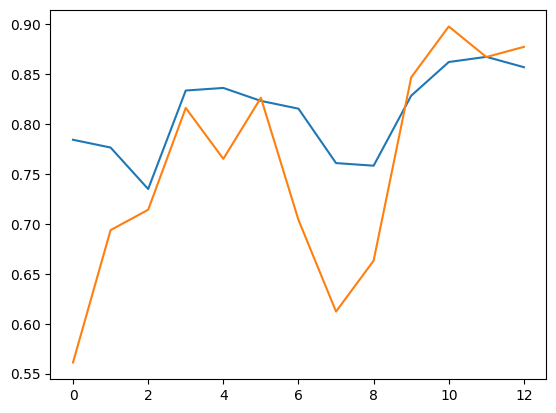

In [55]:
plt.plot(train_acc_hist)
plt.plot(val_acc_hist)
plt.show()

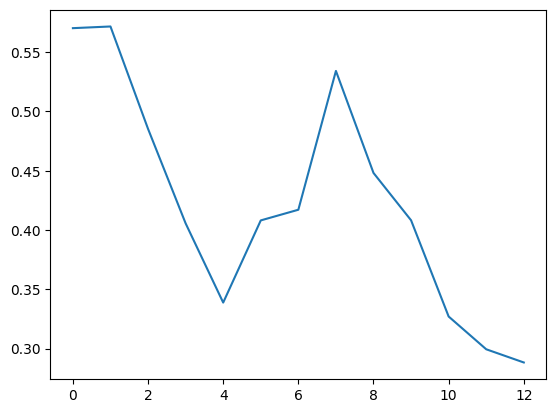

In [56]:
plt.plot(train_loss_hist)
plt.show()

In [57]:

def im_convert(tensor):
    image = tensor.clone().detach().numpy() # 기존 텐서를 복사하지만 기울기가 전파되지 않는다.
    image = image.transpose(1, 2, 0)
    image = image * (np.array((0.5, 0.5, 0.5)) + np.array((0.5, 0.5, 0.5)))
    image = image.clip(0, 1) # 입력 값이 주어진 범위를 벗어날 떄 입력 값을 특정 범위로 제한시키기 위해 사용
    return image

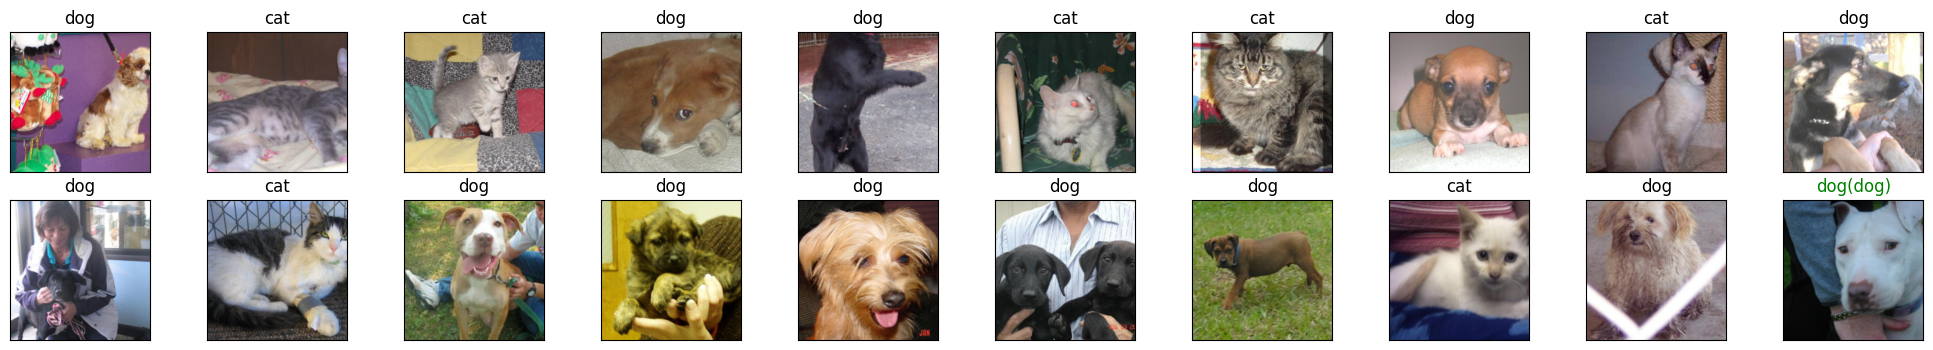

<Figure size 640x480 with 0 Axes>

In [59]:
classes = {0: 'cat', 1: 'dog'}

dataiter = iter(test_loader)
images, labels = next(dataiter) # 테스트셋에서 이미지와 레이블 분리하여 가져오기

output = model(images)
_, preds = torch.max(output, 1)

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx + 1, xticks=[], yticks=[])
    plt.imshow(im_convert(images[idx]))
    ax.set_title(classes[labels[idx].item()])
ax.set_title("{}({})".format(str(classes[preds[idx].item()]), str(classes[labels[idx].item()])), color = ("green" if preds[idx] == labels[idx] else "red"))

plt.show()
plt.subplots_adjust(bottom = 0.2, top = 0.6, hspace = 0)

In [75]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.transforms import ToTensor
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [61]:
class XAI(torch.nn.Module):
    def __init__(self, num_classes=2):
        super(XAI, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias = False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(128, 128, kernel_size=3, padding = 1, bias = False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(256, 256, kernel_size=3, padding = 1, bias = False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.4),
            nn.Conv2d(512, 512, kernel_size=3, padding = 1, bias = False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(512, 512, bias = False),
            nn.Dropout(0.5),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace= True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 512)
        x = self.classifier(x)
        return F.log_softmax(x)

In [73]:
model = XAI()
model.cpu()
model.eval()

XAI(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Dropout(p=0.4, inplace=False)
    (12): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU(inplace=True

In [67]:
class LayerActivations:
    features = []
    def __init__(self, model, layer_num):
        self.hook = model[layer_num].register_forward_hook(self.hook_fn)
        
    def hook_fn(self, module, input, output):
        self.features = output.detach().numpy()
    
    def remove(self):
        self.hook.remove()

torch.Size([1, 3, 100, 100])


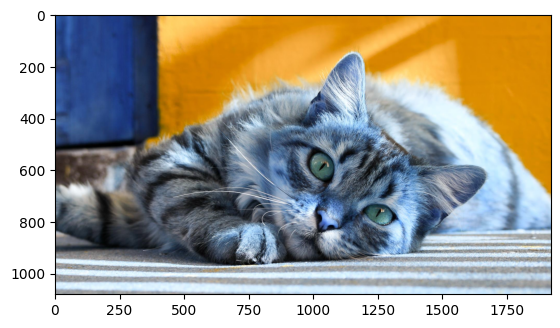

In [68]:
img = cv2.imread("./data/cat.jpg")
plt.imshow(img)
img = cv2.resize(img, (100, 100), interpolation=cv2.INTER_LINEAR)
img = ToTensor()(img).unsqueeze(0) # unsqueeze = 1차원 데이터를 생성하는 함수
print(img.shape)

In [77]:
result = LayerActivations(model.features, 0)


model(img)
activations = result.features


C:\Users\sangil\AppData\Local\Temp\ipykernel_14872\1389393215.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


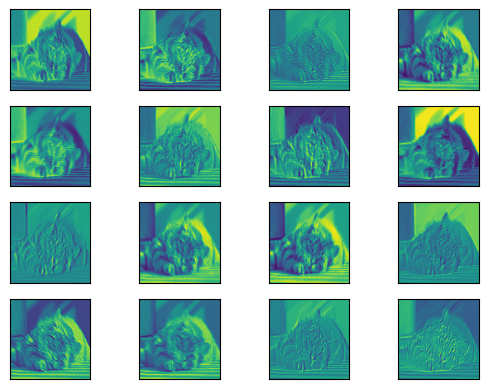

<Figure size 1200x800 with 0 Axes>

In [78]:
fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left = 0, right = 1, bottom=0, top=1, hspace = 0.05, wspace = 0.05)

for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
        
plt.show()

In [79]:
result = LayerActivations(model.features, 20)

model(img)
activations = result.features

C:\Users\sangil\AppData\Local\Temp\ipykernel_14872\1389393215.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


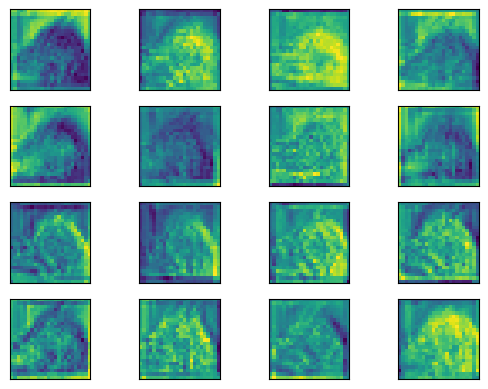

<Figure size 1200x800 with 0 Axes>

In [80]:
fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left = 0, right = 1, bottom=0, top=1, hspace = 0.05, wspace = 0.05)

for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
        
plt.show()

In [81]:
result = LayerActivations(model.features, 40)

model(img)
activations = result.features

C:\Users\sangil\AppData\Local\Temp\ipykernel_14872\1389393215.py:72: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


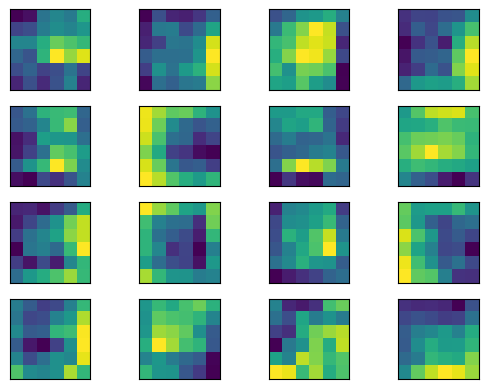

<Figure size 1200x800 with 0 Axes>

In [82]:
fig, axes = plt.subplots(4, 4)
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(left = 0, right = 1, bottom=0, top=1, hspace = 0.05, wspace = 0.05)

for row in range(4):
    for column in range(4):
        axis = axes[row][column]
        axis.get_xaxis().set_ticks([])
        axis.get_yaxis().set_ticks([])
        axis.imshow(activations[0][row*10+column])
        
plt.show()